<a href="https://colab.research.google.com/github/Atabak-Touri/NLP-CNN_RNN/blob/main/RNN_CNN_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**setup and required libraries:**

In [1]:
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


**loading IMDB dataset**

In [2]:

SPLITS = [
    "train+test[:70%]",   #train (70%)
    "train+test[70%:80%]",#validation (10%)
    "train+test[80%:]"    #test (20%)
]

(raw_train, raw_val, raw_test), info = tfds.load(
    "imdb_reviews",
    split=SPLITS,
    as_supervised=True,
    with_info=True
)

print("Examples (train/val/test):",
      sum(1 for _ in raw_train),
      sum(1 for _ in raw_val),
      sum(1 for _ in raw_test))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.PZ4F00_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.PZ4F00_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.PZ4F00_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Examples (train/val/test): 42500 27500 30000


**word embedding:**

In [3]:
# vocab_size=10000 and seq_len=200
VOCAB_SIZE = 10000
SEQ_LEN = 200
BATCH_SIZE = 64
EMBED_DIM = 128

text_vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN
)

# only on training text
train_text_ds = raw_train.map(lambda x, y: x)
text_vectorizer.adapt(train_text_ds) #builds the vocabulary from the training set only (important — no data leakage).

# helper to map text->int sequences and keep label
def vectorize_text(text, label):
    ints = text_vectorizer(text)
    return ints, label


**preparing tf.data pipeline:**

In [4]:
# map, batch, prefetch
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, batch_size=BATCH_SIZE):
    if shuffle:
        ds = ds.shuffle(10000, seed=SEED)
    ds = ds.map(vectorize_text, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = prepare(raw_train, shuffle=True)
val_ds = prepare(raw_val, shuffle=False)
test_ds = prepare(raw_test, shuffle=False)


**building models:**

In [5]:
def build_cnn(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, seq_len=SEQ_LEN):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embed_dim, input_length=seq_len),
        layers.Conv1D(filters=128, kernel_size=5, activation="relu"),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ], name="CNN")
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

def build_rnn(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, seq_len=SEQ_LEN):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embed_dim, input_length=seq_len),
        layers.SimpleRNN(64),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ], name="SimpleRNN")
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model


**training models:**

In [10]:
EPOCHS = 10
early = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# Build models
cnn = build_cnn()
rnn = build_rnn()

# Train CNN
t0 = time.time()
history_cnn = cnn.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early])
cnn_time = time.time() - t0

# Train RNN
t0 = time.time()
history_rnn = rnn.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early])
rnn_time = time.time() - t0

print(f"CNN training time: {cnn_time:.1f}s")
print(f"RNN training time: {rnn_time:.1f}s")


Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7426 - loss: 0.4884 - val_accuracy: 0.9130 - val_loss: 0.2268
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9209 - loss: 0.2038 - val_accuracy: 0.9610 - val_loss: 0.1177
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9720 - loss: 0.0849 - val_accuracy: 0.9887 - val_loss: 0.0414
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9984 - loss: 0.0107 - val_accuracy: 0.9900 - val_loss: 0.0383
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9905 - val_loss: 0.0402
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 1.0000 - loss: 6.0844e-04 - val_accuracy: 0.9904 - val_loss: 0.0424
Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.5023 - loss: 0.6967 - val_accuracy: 0.5039 - val_loss: 0.6935
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.5028 - loss: 0.696

**evaluation:**

In [11]:
test_loss_cnn, test_acc_cnn = cnn.evaluate(test_ds, verbose=2)
test_loss_rnn, test_acc_rnn = rnn.evaluate(test_ds, verbose=2)

print("CNN test accuracy:   ", test_acc_cnn)
print("SimpleRNN test acc:  ", test_acc_rnn)


469/469 - 6s - 14ms/step - accuracy: 0.9815 - loss: 0.0680
469/469 - 6s - 12ms/step - accuracy: 0.5798 - loss: 0.6348
CNN test accuracy:    0.9815333485603333
SimpleRNN test acc:   0.5798333287239075


**plotting:**

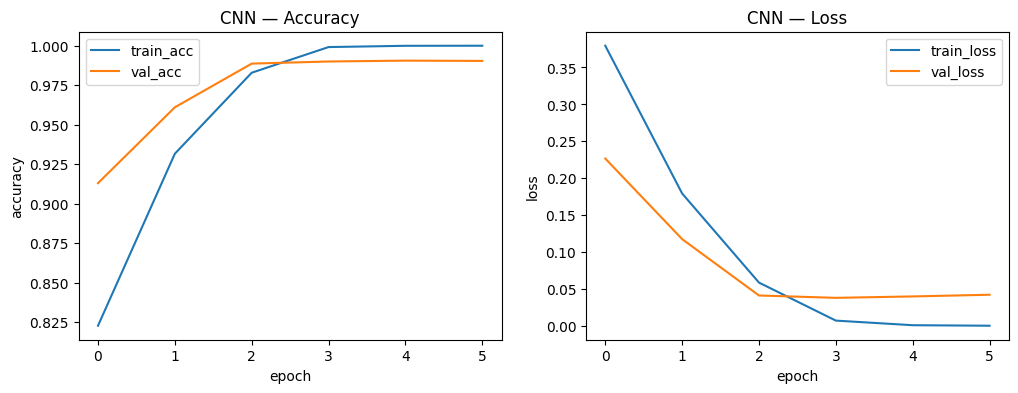

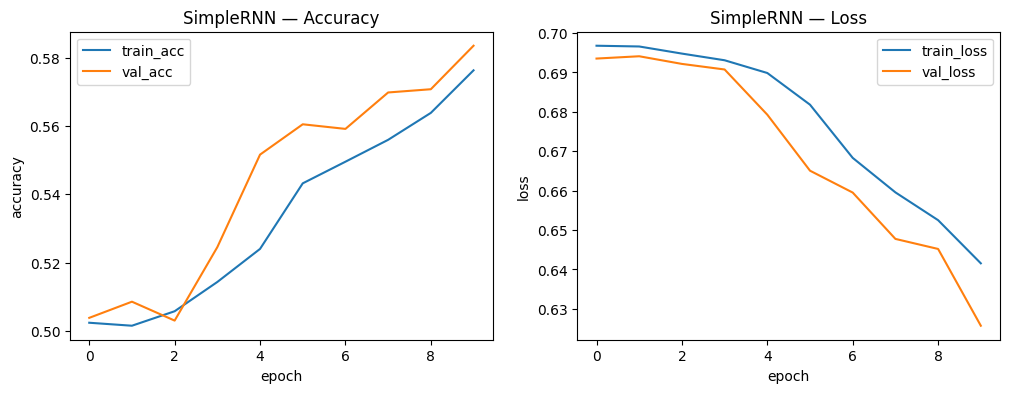

In [12]:
def plot_history(h, title_prefix="Model"):
    plt.figure(figsize=(12,4))
    # accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title(f"{title_prefix} — Accuracy")
    plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend()
    # loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title(f"{title_prefix} — Loss")
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    plt.show()

plot_history(history_cnn, "CNN")
plot_history(history_rnn, "SimpleRNN")


**comparison:**

In [13]:
print("===== Summary =====")
print("CNN:   test_acc={:.4f}, test_loss={:.4f}, train_time={:.1f}s".format(test_acc_cnn, test_loss_cnn, cnn_time))
print("RNN:   test_acc={:.4f}, test_loss={:.4f}, train_time={:.1f}s".format(test_acc_rnn, test_loss_rnn, rnn_time))



===== Summary =====
CNN:   test_acc=0.9815, test_loss=0.0680, train_time=103.5s
RNN:   test_acc=0.5798, test_loss=0.6348, train_time=198.5s
